# Semantic Search and Information Retrieval with Transformers - Interactive Tutorial

Welcome to this interactive tutorial based on Article 9 of the Hugging Face Transformers series. This notebook provides hands-on experience with semantic search, embeddings, and RAG systems.

## Table of Contents

1. [Introduction: From Keywords to Understanding](#introduction)
2. [Setting Up the Environment](#setup)
3. [Keyword vs. Semantic Search](#keyword-vs-semantic)
4. [Understanding Embeddings](#embeddings)
5. [Hybrid Search: Best of Both Worlds](#hybrid-search)
6. [Multilingual Search](#multilingual)
7. [RAG: Retrieval-Augmented Generation](#rag)
8. [Performance Analysis and Benchmarking](#performance)
9. [Exercises and Challenges](#exercises)

## Learning Objectives

By the end of this tutorial, you'll be able to:
- Build semantic search systems using transformer embeddings
- Implement hybrid search combining keyword and semantic approaches
- Create RAG pipelines for enhanced Q&A systems
- Evaluate search quality with appropriate metrics

**Note:** For advanced vector database examples using FAISS, see the separate `faiss_vector_db.ipynb` notebook.

<a id='introduction'></a>
## 1. Introduction: From Keywords to Understanding

Traditional keyword search often fails to understand user intent. Semantic search revolutionizes this by understanding **meaning and context**.

Let's visualize the difference between keyword and semantic search:

In [6]:
# Set environment variable to avoid tokenizers warning
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer, util
from rank_bm25 import BM25Okapi
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully!
NumPy version: 1.26.4
Pandas version: 2.3.1


<a id='setup'></a>
## 2. Setting Up the Environment

First, let's verify our Python environment and set up the necessary components for semantic search.

In [8]:
import sys
print(f"Python version: {sys.version}")

# Load the sentence transformer model
print("\nLoading sentence transformer model...")
model = SentenceTransformer('all-MiniLM-L6-v2')
print("Model loaded successfully!")

# Test the model with a simple example
test_sentence = "Hello, world!"
test_embedding = model.encode(test_sentence)
print(f"\nTest embedding shape: {test_embedding.shape}")
print(f"Embedding dimension: {len(test_embedding)}")

Python version: 3.12.9 (main, Apr 29 2025, 13:57:48) [Clang 16.0.0 (clang-1600.0.26.4)]

Loading sentence transformer model...
Model loaded successfully!

Test embedding shape: (384,)
Embedding dimension: 384


<a id='keyword-vs-semantic'></a>
## 3. Keyword vs. Semantic Search

Let's demonstrate the fundamental difference between keyword and semantic search with a practical example.

### Example: FAQ Search System

We'll create a simple FAQ system and compare how keyword and semantic search handle user queries.

In [9]:
# Define our FAQ documents
faqs = [
    "How can I reset my password?",
    "What are the steps for account recovery?",
    "How do I request a refund?",
    "Information about our privacy policy.",
    "How to update billing information?",
    "Contact customer support for help.",
    "Two-factor authentication setup guide.",
    "Troubleshooting login issues."
]

# User query that doesn't match keywords exactly
query = "I forgot my login credentials"

print(f"User Query: '{query}'")
print("\n" + "="*50 + "\n")

User Query: 'I forgot my login credentials'




In [10]:
# Keyword Search Implementation
def keyword_search(query, documents):
    """Simple keyword matching search"""
    query_words = set(query.lower().split())
    matches = []
    
    for doc in documents:
        doc_words = set(doc.lower().split())
        if query_words & doc_words:  # Intersection
            matches.append(doc)
    
    return matches

# Perform keyword search
keyword_results = keyword_search(query, faqs)
print("🔍 KEYWORD SEARCH RESULTS:")
if keyword_results:
    for i, result in enumerate(keyword_results, 1):
        print(f"  {i}. {result}")
else:
    print("  No matches found! ❌")
    print("  (No shared words between query and documents)")

🔍 KEYWORD SEARCH RESULTS:
  1. How can I reset my password?
  2. How do I request a refund?
  3. Troubleshooting login issues.


In [11]:
# Semantic Search Implementation
def semantic_search(query, documents, model, top_k=3):
    """Semantic search using sentence transformers"""
    # Encode query and documents
    query_embedding = model.encode(query, convert_to_numpy=True)
    doc_embeddings = model.encode(documents, convert_to_numpy=True)
    
    # Calculate cosine similarities
    similarities = util.cos_sim(query_embedding, doc_embeddings)[0]
    
    # Get top-k results
    top_results = similarities.argsort(descending=True)[:top_k]
    
    results = [(documents[idx], float(similarities[idx])) for idx in top_results]
    return results

# Perform semantic search
semantic_results = semantic_search(query, faqs, model)
print("\n🧠 SEMANTIC SEARCH RESULTS:")
for i, (doc, score) in enumerate(semantic_results, 1):
    print(f"  {i}. {doc}")
    print(f"     (Similarity score: {score:.3f})")


🧠 SEMANTIC SEARCH RESULTS:
  1. How can I reset my password?
     (Similarity score: 0.667)
  2. Troubleshooting login issues.
     (Similarity score: 0.538)
  3. What are the steps for account recovery?
     (Similarity score: 0.453)


### Visualizing the Difference

Let's create a visualization showing how semantic search finds relevant results even when keywords don't match:

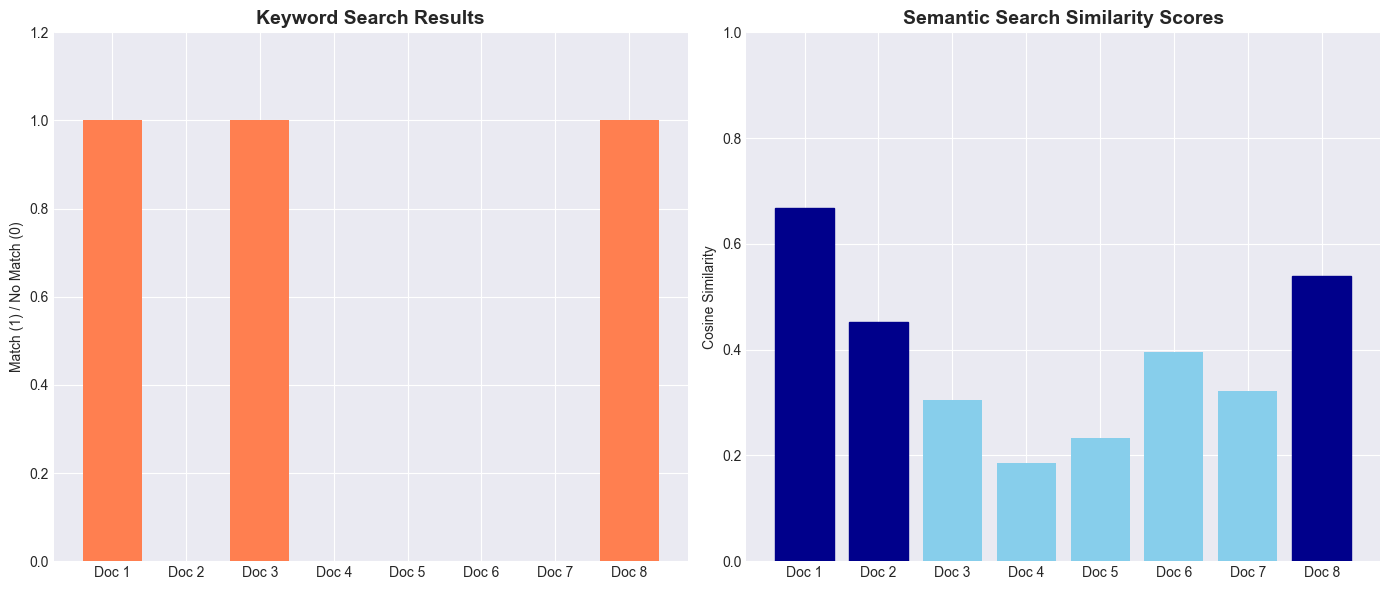


Document Mapping:
Doc 1: How can I reset my password?...
Doc 2: What are the steps for account recovery?...
Doc 3: How do I request a refund?...
Doc 4: Information about our privacy policy....
Doc 5: How to update billing information?...
Doc 6: Contact customer support for help....
Doc 7: Two-factor authentication setup guide....
Doc 8: Troubleshooting login issues....


In [12]:
# Create a comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Keyword search visualization
keyword_data = pd.DataFrame({
    'Document': ['Doc ' + str(i+1) for i in range(len(faqs))],
    'Match': [1 if faq in keyword_results else 0 for faq in faqs]
})

ax1.bar(keyword_data['Document'], keyword_data['Match'], color='coral')
ax1.set_title('Keyword Search Results', fontsize=14, fontweight='bold')
ax1.set_ylabel('Match (1) / No Match (0)')
ax1.set_ylim(0, 1.2)

# Semantic search visualization
query_emb = model.encode(query)
doc_embs = model.encode(faqs)
all_similarities = util.cos_sim(query_emb, doc_embs)[0].numpy()

semantic_data = pd.DataFrame({
    'Document': ['Doc ' + str(i+1) for i in range(len(faqs))],
    'Similarity': all_similarities
})

bars = ax2.bar(semantic_data['Document'], semantic_data['Similarity'], color='skyblue')
ax2.set_title('Semantic Search Similarity Scores', fontsize=14, fontweight='bold')
ax2.set_ylabel('Cosine Similarity')
ax2.set_ylim(0, 1.0)

# Highlight top 3 results
top_3_indices = all_similarities.argsort()[-3:][::-1]
for idx in top_3_indices:
    bars[idx].set_color('darkblue')

plt.tight_layout()
plt.show()

# Print the FAQ mapping
print("\nDocument Mapping:")
for i, faq in enumerate(faqs):
    print(f"Doc {i+1}: {faq[:50]}...")

<a id='embeddings'></a>
## 4. Understanding Embeddings

Embeddings are the foundation of semantic search. Let's explore how they work and visualize them.

### What are Embeddings?

Embeddings are dense vector representations of text that capture semantic meaning. Similar texts have similar embeddings.

In [13]:
# Generate embeddings for different types of sentences
sentences = [
    # Similar meanings
    "How do I reset my password?",
    "What are the steps to recover my account?",
    "I forgot my login credentials",
    
    # Different topic
    "The weather is nice today",
    "It's a beautiful sunny day",
    
    # Another different topic
    "Machine learning is fascinating",
    "AI and deep learning are interesting"
]

# Generate embeddings
embeddings = model.encode(sentences)
print(f"Generated embeddings for {len(sentences)} sentences")
print(f"Embedding shape: {embeddings.shape}")

Generated embeddings for 7 sentences
Embedding shape: (7, 384)


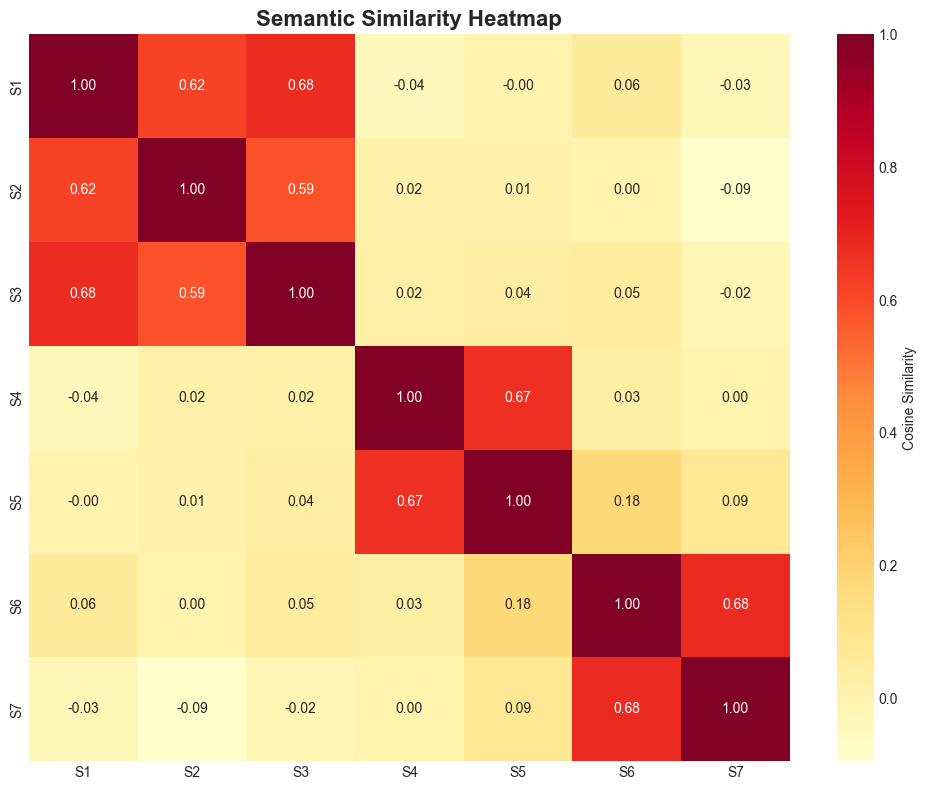


Sentence Mapping:
S1: How do I reset my password?
S2: What are the steps to recover my account?
S3: I forgot my login credentials
S4: The weather is nice today
S5: It's a beautiful sunny day
S6: Machine learning is fascinating
S7: AI and deep learning are interesting


In [14]:
# Calculate similarity matrix
similarity_matrix = util.cos_sim(embeddings, embeddings).numpy()

# Create a heatmap visualization
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap="YlOrRd",
            xticklabels=[f"S{i+1}" for i in range(len(sentences))],
            yticklabels=[f"S{i+1}" for i in range(len(sentences))],
            cbar_kws={'label': 'Cosine Similarity'})

plt.title("Semantic Similarity Heatmap", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print sentence mapping
print("\nSentence Mapping:")
for i, sent in enumerate(sentences):
    print(f"S{i+1}: {sent}")

### Visualizing Embeddings in 2D

Let's reduce the dimensionality of embeddings to visualize them in 2D space using t-SNE:

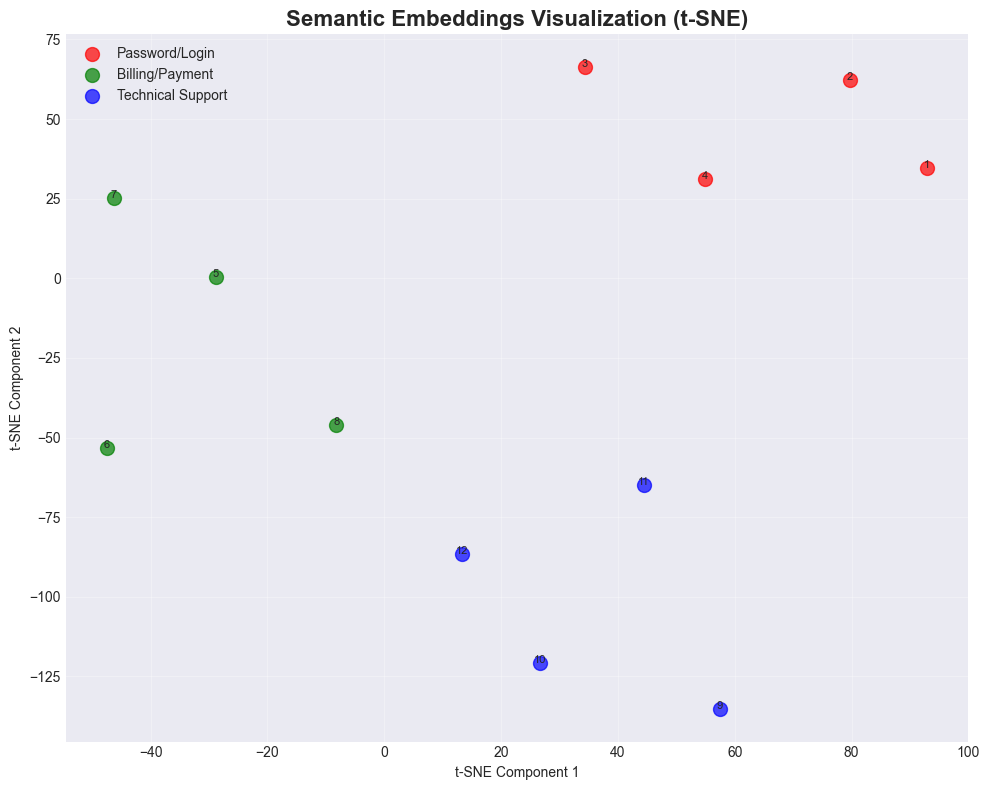


Sentence Mapping:
1. [Password/Login] How do I reset my password?
2. [Password/Login] Forgot my login credentials
3. [Password/Login] Account recovery steps
4. [Password/Login] Can't access my account
5. [Billing/Payment] How to update payment method?
6. [Billing/Payment] Request a refund
7. [Billing/Payment] Billing information update
8. [Billing/Payment] Payment failed issues
9. [Technical Support] App crashes frequently
10. [Technical Support] Software bug report
11. [Technical Support] Technical difficulties
12. [Technical Support] System error messages


In [15]:
from sklearn.manifold import TSNE

# Generate more embeddings for better visualization
categories = {
    "Password/Login": [
        "How do I reset my password?",
        "Forgot my login credentials",
        "Account recovery steps",
        "Can't access my account"
    ],
    "Billing/Payment": [
        "How to update payment method?",
        "Request a refund",
        "Billing information update",
        "Payment failed issues"
    ],
    "Technical Support": [
        "App crashes frequently",
        "Software bug report",
        "Technical difficulties",
        "System error messages"
    ]
}

# Prepare data
all_sentences = []
labels = []
colors = []
color_map = {'Password/Login': 'red', 'Billing/Payment': 'green', 'Technical Support': 'blue'}

for category, sents in categories.items():
    all_sentences.extend(sents)
    labels.extend([category] * len(sents))
    colors.extend([color_map[category]] * len(sents))

# Generate embeddings
all_embeddings = model.encode(all_sentences)

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Create visualization
plt.figure(figsize=(10, 8))

for category in categories.keys():
    mask = np.array(labels) == category
    plt.scatter(embeddings_2d[mask, 0], 
                embeddings_2d[mask, 1], 
                c=color_map[category], 
                label=category, 
                alpha=0.7, 
                s=100)

# Add annotations
for i, txt in enumerate(all_sentences):
    plt.annotate(f"{i+1}", 
                 (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                 fontsize=8,
                 ha='center')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Semantic Embeddings Visualization (t-SNE)', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print sentence mapping
print("\nSentence Mapping:")
for i, (sent, cat) in enumerate(zip(all_sentences, labels)):
    print(f"{i+1}. [{cat}] {sent}")

<a id='hybrid-search'></a>
## 5. Hybrid Search: Best of Both Worlds

Hybrid search combines keyword matching (BM25) with semantic search for optimal results. Let's implement and compare different approaches.

In [16]:
# Import our hybrid search implementation
import sys
sys.path.append('../src')
from hybrid_search import HybridSearchEngine

# Create sample documents
documents = [
    "How to reset your password: Click forgot password on login page",
    "Account recovery steps for forgotten credentials",
    "Password reset instructions and security guidelines",
    "Update your profile information in account settings",
    "Two-factor authentication setup guide",
    "Troubleshooting login issues and access problems",
    "Security best practices for strong passwords",
    "How to change your email address in settings",
    "Recovering locked accounts after failed login attempts",
    "Password manager recommendations for secure storage"
]

# Initialize hybrid search engine
hybrid_engine = HybridSearchEngine()
hybrid_engine.index_documents(documents)
print("Hybrid search engine initialized!")

Initializing hybrid search engine...
Semantic model: all-MiniLM-L6-v2
Weights - Keyword: 0.3, Semantic: 0.7

Indexing 10 documents...
Building BM25 index...
Generating semantic embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Indexing completed in 0.06 seconds
Hybrid search engine initialized!


In [17]:
# Test different queries with varying lengths
test_queries = [
    "reset",  # Very short - keyword heavy
    "forgot password",  # Short - balanced
    "I can't remember my login",  # Medium - balanced  
    "What are the steps to recover my account when I've forgotten my password?"  # Long - semantic heavy
]

# Compare search approaches
results_comparison = []

for query in test_queries:
    # Get adaptive weights
    kw_weight, sem_weight = hybrid_engine.adaptive_weighting(query)
    
    # Perform search
    results = hybrid_engine.search(query, k=3, return_scores=True)
    
    results_comparison.append({
        'query': query,
        'query_length': len(query.split()),
        'keyword_weight': kw_weight,
        'semantic_weight': sem_weight,
        'top_result': results[0]['document'][:50] + '...' if results else 'No results',
        'top_score': results[0]['hybrid_score'] if results else 0
    })

# Create comparison table
comparison_df = pd.DataFrame(results_comparison)
print("\n🔍 Adaptive Weight Analysis:")
print("="*80)
display(comparison_df)


🔍 Adaptive Weight Analysis:


,query,query_length,keyword_weight,semantic_weight,top_result,top_score
0,reset,1,0.5,0.5,Password reset instructions and security guide...,0.748499
1,forgot password,2,0.5,0.5,How to reset your password: Click forgot passw...,0.872742
2,I can't remember my login,5,0.3,0.7,How to reset your password: Click forgot passw...,0.692617
3,What are the steps to recover my account when ...,13,0.3,0.7,Account recovery steps for forgotten credentia...,0.857792


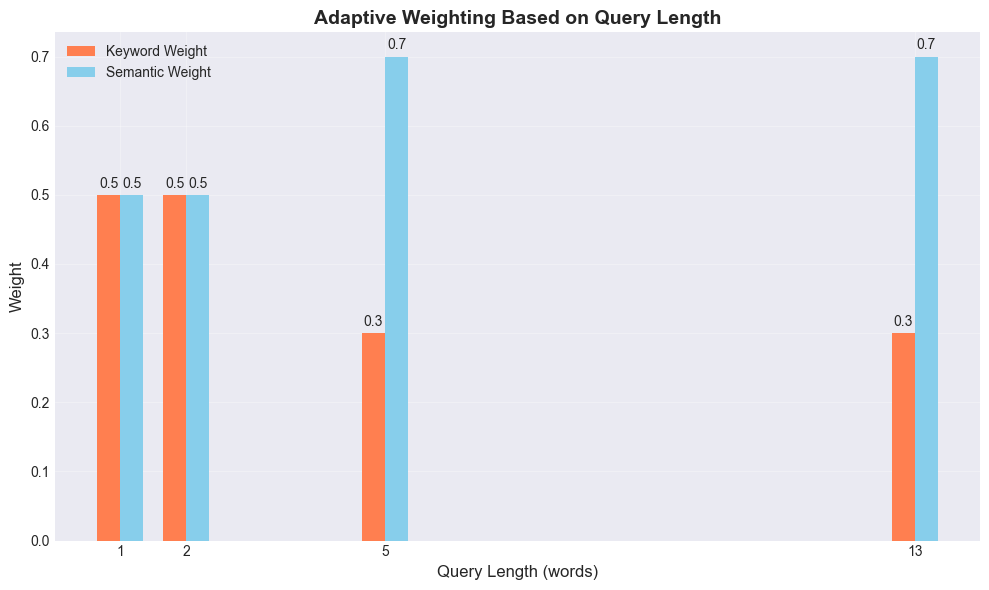

In [18]:
# Visualize weight adaptation
fig, ax = plt.subplots(figsize=(10, 6))

x = comparison_df['query_length']
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['keyword_weight'], width, label='Keyword Weight', color='coral')
bars2 = ax.bar(x + width/2, comparison_df['semantic_weight'], width, label='Semantic Weight', color='skyblue')

ax.set_xlabel('Query Length (words)', fontsize=12)
ax.set_ylabel('Weight', fontsize=12)
ax.set_title('Adaptive Weighting Based on Query Length', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Comparing Search Approaches

Let's evaluate how different search approaches perform on the same queries:


Evaluating search approaches...


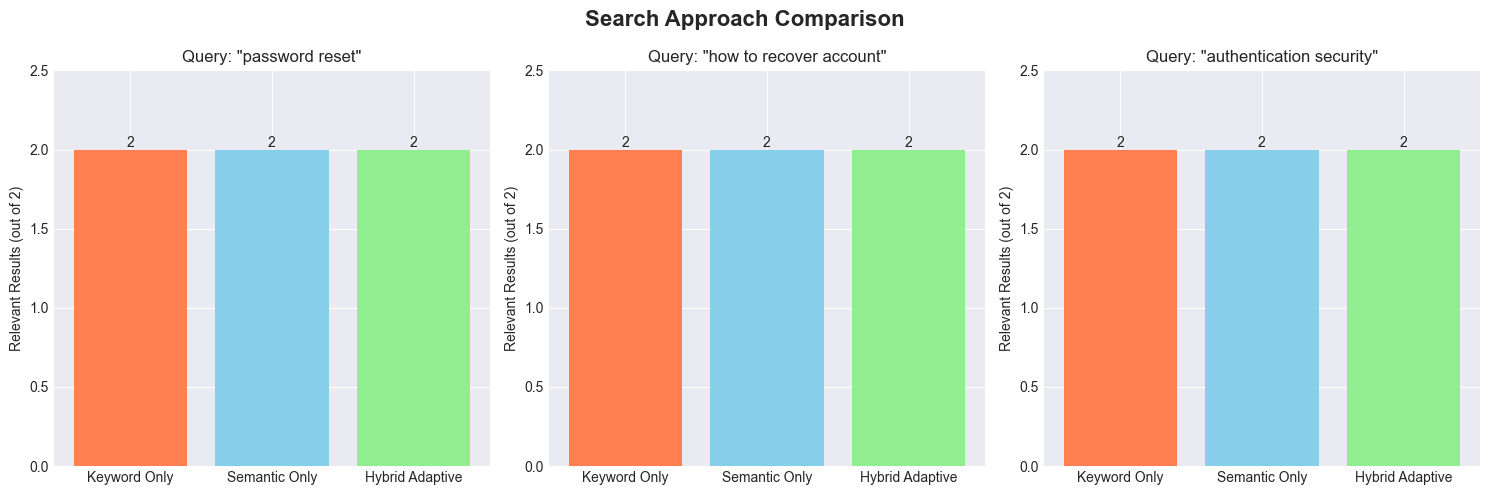

In [19]:
# Evaluate different approaches
evaluation_queries = [
    "password reset",
    "how to recover account",
    "authentication security"
]

evaluation_results = hybrid_engine.evaluate_approaches(evaluation_queries, k=2)

# Create visualization comparing approaches
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
approaches = ['keyword_only', 'semantic_only', 'hybrid_adaptive']
approach_names = ['Keyword Only', 'Semantic Only', 'Hybrid Adaptive']

for idx, (query, ax) in enumerate(zip(evaluation_queries, axes)):
    # Count how many relevant results each approach found
    relevance_scores = []
    
    for approach in approaches:
        results = evaluation_results[approach][idx]
        # Simple relevance: check if results contain key terms
        relevant_count = sum(1 for r in results if any(term in r.lower() 
                           for term in query.lower().split()))
        relevance_scores.append(relevant_count)
    
    bars = ax.bar(approach_names, relevance_scores, 
                   color=['coral', 'skyblue', 'lightgreen'])
    ax.set_title(f'Query: "{query}"', fontsize=12)
    ax.set_ylabel('Relevant Results (out of 2)')
    ax.set_ylim(0, 2.5)
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom')

plt.suptitle('Search Approach Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [20]:
# Generate a larger dataset for FAISS demonstration
import numpy as np  # Add numpy import
np.random.seed(42)

# Create synthetic documents
num_documents = 1000
categories = ['tech', 'health', 'finance', 'education', 'travel']
synthetic_docs = []

templates = {
    'tech': ['software', 'hardware', 'programming', 'AI', 'data'],
    'health': ['wellness', 'medicine', 'fitness', 'nutrition', 'mental'],
    'finance': ['investment', 'banking', 'budget', 'savings', 'credit'],
    'education': ['learning', 'teaching', 'courses', 'degree', 'skills'],
    'travel': ['vacation', 'destination', 'flights', 'hotels', 'adventure']
}

for i in range(num_documents):
    cat = np.random.choice(categories)
    word = np.random.choice(templates[cat])
    synthetic_docs.append(f"Document about {word} in {cat} category #{i}")

print(f"Generated {len(synthetic_docs)} synthetic documents")
print("\nSample documents:")
for i in range(5):
    print(f"  - {synthetic_docs[i]}")

Generated 1000 synthetic documents

Sample documents:
  - Document about skills in education category #0
  - Document about credit in finance category #1
  - Document about destination in travel category #2
  - Document about budget in finance category #3
  - Document about credit in finance category #4


In [21]:
# Compare different FAISS index types
import time

# Make sure doc_embeddings is defined
if 'doc_embeddings' not in globals():
    print("Please run the previous cell first to generate embeddings!")
else:
    dimension = doc_embeddings.shape[1]
    indices = {}
    build_times = {}

    # 1. Exact search (IndexFlatL2)
    start = time.time()
    index_flat = faiss.IndexFlatL2(dimension)
    index_flat.add(doc_embeddings)
    build_times['Flat L2 (Exact)'] = time.time() - start
    indices['Flat L2 (Exact)'] = index_flat

    # 2. Approximate search (IndexIVFFlat)
    start = time.time()
    nlist = 50  # Number of clusters
    quantizer = faiss.IndexFlatL2(dimension)
    index_ivf = faiss.IndexIVFFlat(quantizer, dimension, nlist)
    index_ivf.train(doc_embeddings)  # Training required
    index_ivf.add(doc_embeddings)
    build_times['IVF Flat (Approximate)'] = time.time() - start
    indices['IVF Flat (Approximate)'] = index_ivf

    # 3. Graph-based search (IndexHNSWFlat)
    start = time.time()
    index_hnsw = faiss.IndexHNSWFlat(dimension, 32)  # 32 is the connectivity parameter
    index_hnsw.add(doc_embeddings)
    build_times['HNSW (Graph)'] = time.time() - start
    indices['HNSW (Graph)'] = index_hnsw

    print("Index Build Times:")
    for name, time_taken in build_times.items():
        print(f"  {name}: {time_taken:.3f} seconds")

Please run the previous cell first to generate embeddings!


In [22]:
# Benchmark search performance
if 'indices' not in globals() or not indices:
    print("Please run the previous cell first to build indices!")
else:
    query = "Looking for AI and machine learning resources"
    query_embedding = model.encode([query]).astype('float32')
    k = 10  # Number of neighbors

    search_times = {}
    search_results = {}

    for name, index in indices.items():
        # Set search parameters for IVF
        if 'IVF' in name:
            index.nprobe = 10  # Number of clusters to search
        
        # Perform search
        start = time.time()
        distances, indices_found = index.search(query_embedding, k)
        search_times[name] = (time.time() - start) * 1000  # Convert to ms
        search_results[name] = (distances[0], indices_found[0])

    # Visualize performance comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Build times
    names = list(build_times.keys())
    build_values = list(build_times.values())
    ax1.bar(names, build_values, color=['green', 'orange', 'blue'])
    ax1.set_title('Index Build Time Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Time (seconds)')
    ax1.tick_params(axis='x', rotation=45)

    # Search times
    search_values = list(search_times.values())
    ax2.bar(names, search_values, color=['green', 'orange', 'blue'])
    ax2.set_title('Search Time Comparison', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Time (milliseconds)')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Display search results
    print(f"\nQuery: '{query}'")
    print("\nTop 5 results from each index type:")
    for name, (distances, indices_found) in search_results.items():
        print(f"\n{name}:")
        for i in range(5):
            idx = indices_found[i]
            dist = distances[i]
            print(f"  {i+1}. {synthetic_docs[idx][:60]}... (distance: {dist:.3f})")

Please run the previous cell first to build indices!


In [23]:
# Load multilingual model
print("Loading multilingual model...")
multilingual_model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
print("Multilingual model loaded!")

# Create multilingual FAQ dataset
multilingual_faqs = [
    # English
    "How do I reset my password?",
    "Contact customer support",
    "Refund policy information",
    
    # Spanish
    "¿Cómo puedo restablecer mi contraseña?",
    "Contactar con atención al cliente",
    "Información sobre política de reembolso",
    
    # French
    "Comment réinitialiser mon mot de passe?",
    "Contacter le support client",
    "Informations sur la politique de remboursement",
    
    # German
    "Wie kann ich mein Passwort zurücksetzen?",
    "Kundensupport kontaktieren",
    "Informationen zur Rückerstattungsrichtlinie"
]

languages = ['English', 'English', 'English', 
             'Spanish', 'Spanish', 'Spanish',
             'French', 'French', 'French',
             'German', 'German', 'German']

# Generate multilingual embeddings
multilingual_embeddings = multilingual_model.encode(multilingual_faqs)

Loading multilingual model...
Multilingual model loaded!


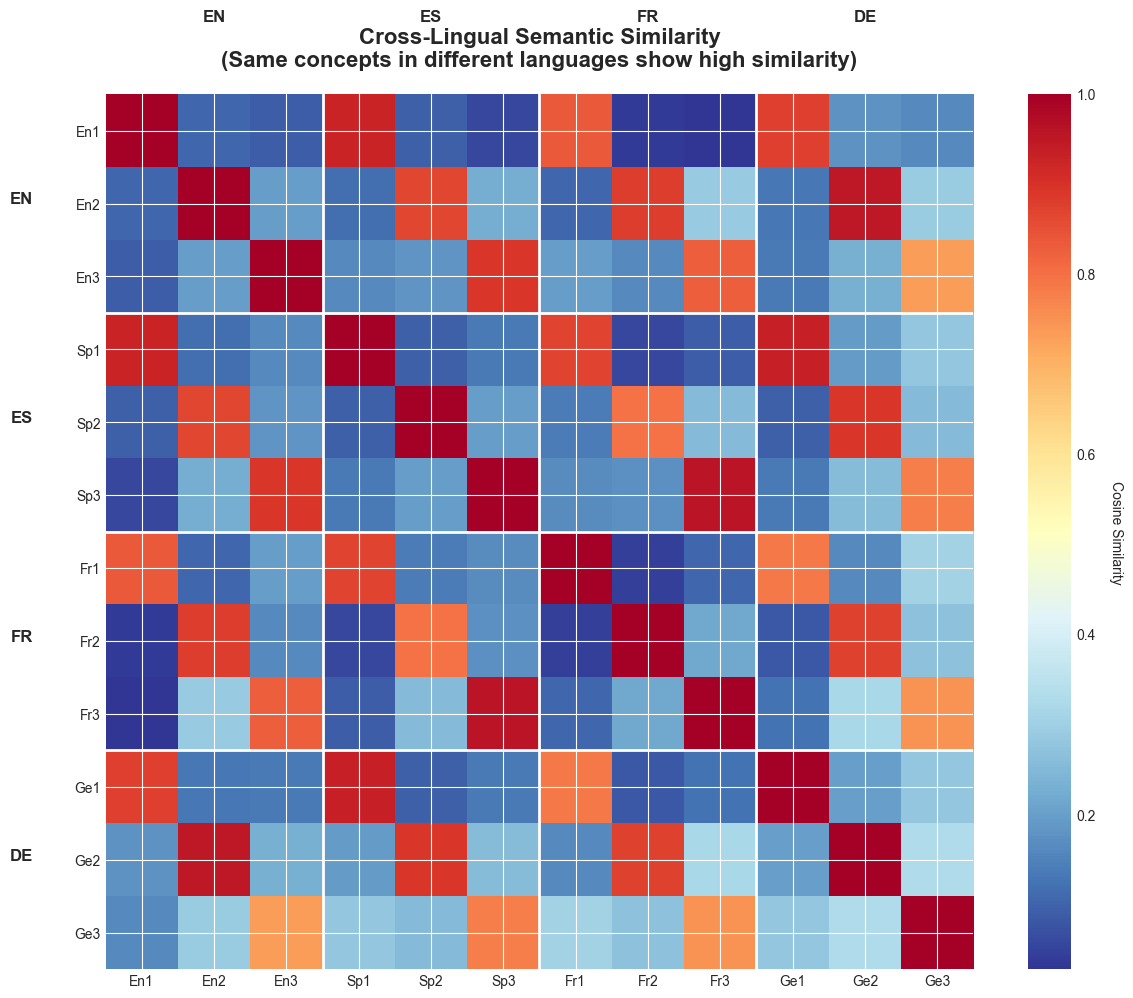


Legend:
EN1-3: English sentences | ES1-3: Spanish sentences
FR1-3: French sentences | DE1-3: German sentences

1: Password reset | 2: Customer support | 3: Refund policy


In [24]:
# Visualize multilingual similarity matrix
similarity_matrix = util.cos_sim(multilingual_embeddings, multilingual_embeddings).numpy()

# Create structured heatmap
fig, ax = plt.subplots(figsize=(12, 10))

# Create labels
labels = [f"{lang[:2]}{i%3+1}" for i, lang in enumerate(languages)]

# Plot heatmap
im = ax.imshow(similarity_matrix, cmap='RdYlBu_r', aspect='auto')

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Cosine Similarity', rotation=270, labelpad=20)

# Set ticks and labels
ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Add grid lines to separate language groups
for i in range(3, 12, 3):
    ax.axhline(i-0.5, color='white', linewidth=2)
    ax.axvline(i-0.5, color='white', linewidth=2)

# Add language group labels
lang_groups = ['EN', 'ES', 'FR', 'DE']
for i, lang in enumerate(lang_groups):
    ax.text(-1.5, i*3+1, lang, fontsize=12, fontweight='bold', ha='right')
    ax.text(i*3+1, -1.5, lang, fontsize=12, fontweight='bold', ha='center')

ax.set_title('Cross-Lingual Semantic Similarity\n(Same concepts in different languages show high similarity)', 
             fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Print legend
print("\nLegend:")
print("EN1-3: English sentences | ES1-3: Spanish sentences")
print("FR1-3: French sentences | DE1-3: German sentences")
print("\n1: Password reset | 2: Customer support | 3: Refund policy")

In [25]:
# Import RAG components
from transformers import pipeline

# Create a knowledge base
knowledge_base = [
    "Our refund policy allows returns within 30 days of purchase. To initiate a refund, contact customer support with your order number.",
    "Password reset: Click 'Forgot Password' on the login page. Enter your email address and check your inbox for reset instructions.",
    "Two-factor authentication adds an extra layer of security. Enable it in your account settings under the Security tab.",
    "Premium subscription includes unlimited storage, priority support, and advanced analytics features for $19.99/month.",
    "Technical support is available 24/7 via email at support@example.com or through live chat on our website.",
    "Account suspension may occur due to policy violations. Contact support to appeal or learn more about the suspension.",
    "Data privacy: We use industry-standard encryption and never share your personal information with third parties.",
    "API rate limits: Free tier allows 1000 requests/day. Premium users get 10,000 requests/day with no throttling."
]

# Create embeddings for knowledge base
kb_embeddings = model.encode(knowledge_base)
print(f"Knowledge base contains {len(knowledge_base)} documents")

Knowledge base contains 8 documents


In [26]:
# Simple RAG implementation
def simple_rag(query, knowledge_base, kb_embeddings, model, top_k=2):
    """
    Simple RAG: Retrieve relevant context and generate response
    """
    # Step 1: Retrieve relevant documents
    query_embedding = model.encode(query)
    similarities = util.cos_sim(query_embedding, kb_embeddings)[0]
    top_indices = similarities.argsort(descending=True)[:top_k]
    
    # Get retrieved documents
    retrieved_docs = [knowledge_base[idx] for idx in top_indices]
    retrieved_scores = [float(similarities[idx]) for idx in top_indices]
    
    # Step 2: Create context for generation
    context = "\n\n".join(retrieved_docs)
    
    # Step 3: Generate response (using a simple template for demonstration)
    # In production, you would use a proper LLM here
    response = f"""Based on the information in our knowledge base:

{context}

To answer your question about '{query}':
{retrieved_docs[0]}

This information was retrieved with {retrieved_scores[0]:.1%} confidence."""
    
    return response, retrieved_docs, retrieved_scores

# Test RAG system
test_questions = [
    "How do I get a refund?",
    "Is my data secure?",
    "What are the API limits?"
]

for question in test_questions:
    print(f"\n{'='*60}")
    print(f"❓ Question: {question}")
    response, docs, scores = simple_rag(question, knowledge_base, kb_embeddings, model)
    print(f"\n📚 Retrieved Documents:")
    for i, (doc, score) in enumerate(zip(docs, scores)):
        print(f"  {i+1}. (Score: {score:.3f}) {doc[:80]}...")
    print(f"\n💡 Generated Response:")
    print(response)


❓ Question: How do I get a refund?

📚 Retrieved Documents:
  1. (Score: 0.601) Our refund policy allows returns within 30 days of purchase. To initiate a refun...
  2. (Score: 0.270) Account suspension may occur due to policy violations. Contact support to appeal...

💡 Generated Response:
Based on the information in our knowledge base:

Our refund policy allows returns within 30 days of purchase. To initiate a refund, contact customer support with your order number.

Account suspension may occur due to policy violations. Contact support to appeal or learn more about the suspension.

To answer your question about 'How do I get a refund?':
Our refund policy allows returns within 30 days of purchase. To initiate a refund, contact customer support with your order number.

This information was retrieved with 60.1% confidence.

❓ Question: Is my data secure?

📚 Retrieved Documents:
  1. (Score: 0.503) Data privacy: We use industry-standard encryption and never share your personal ...
  2. (

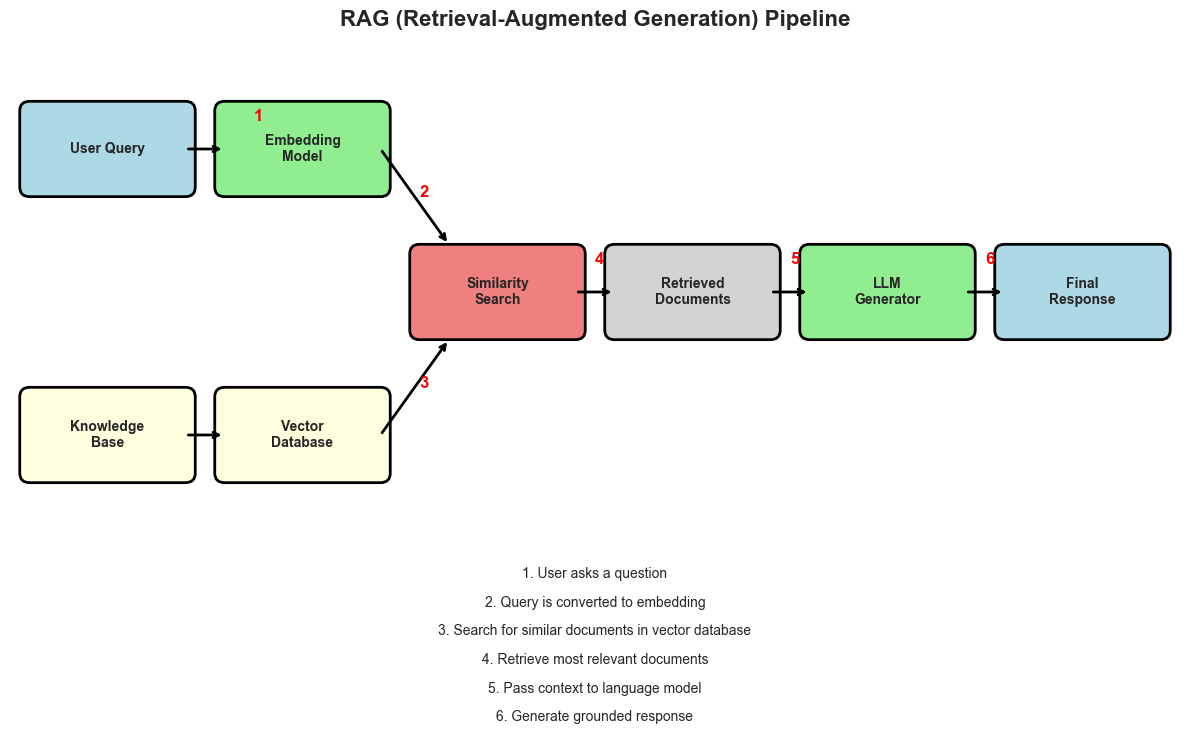

In [27]:
# Visualize RAG pipeline
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(12, 8))

# Define components
components = [
    {"name": "User Query", "pos": (1, 7), "color": "lightblue"},
    {"name": "Embedding\nModel", "pos": (3, 7), "color": "lightgreen"},
    {"name": "Knowledge\nBase", "pos": (1, 4), "color": "lightyellow"},
    {"name": "Vector\nDatabase", "pos": (3, 4), "color": "lightyellow"},
    {"name": "Similarity\nSearch", "pos": (5, 5.5), "color": "lightcoral"},
    {"name": "Retrieved\nDocuments", "pos": (7, 5.5), "color": "lightgray"},
    {"name": "LLM\nGenerator", "pos": (9, 5.5), "color": "lightgreen"},
    {"name": "Final\nResponse", "pos": (11, 5.5), "color": "lightblue"}
]

# Draw components
for comp in components:
    rect = patches.FancyBboxPatch(
        (comp["pos"][0]-0.8, comp["pos"][1]-0.4),
        1.6, 0.8,
        boxstyle="round,pad=0.1",
        facecolor=comp["color"],
        edgecolor="black",
        linewidth=2
    )
    ax.add_patch(rect)
    ax.text(comp["pos"][0], comp["pos"][1], comp["name"], 
            ha="center", va="center", fontsize=10, fontweight="bold")

# Draw arrows
arrows = [
    ((1.8, 7), (2.2, 7)),      # Query to Embedding
    ((3.8, 7), (4.5, 6)),      # Embedding to Similarity
    ((3.8, 4), (4.5, 5)),      # Vector DB to Similarity
    ((1.8, 4), (2.2, 4)),      # KB to Vector DB
    ((5.8, 5.5), (6.2, 5.5)),  # Similarity to Retrieved
    ((7.8, 5.5), (8.2, 5.5)),  # Retrieved to LLM
    ((9.8, 5.5), (10.2, 5.5)), # LLM to Response
]

for start, end in arrows:
    ax.annotate("", xy=end, xytext=start,
                arrowprops=dict(arrowstyle="->", lw=2, color="black"))

# Add labels
ax.text(2.5, 7.3, "1", fontsize=12, fontweight="bold", color="red")
ax.text(4.2, 6.5, "2", fontsize=12, fontweight="bold", color="red")
ax.text(4.2, 4.5, "3", fontsize=12, fontweight="bold", color="red")
ax.text(6, 5.8, "4", fontsize=12, fontweight="bold", color="red")
ax.text(8, 5.8, "5", fontsize=12, fontweight="bold", color="red")
ax.text(10, 5.8, "6", fontsize=12, fontweight="bold", color="red")

ax.set_xlim(0, 12)
ax.set_ylim(3, 8)
ax.axis('off')
ax.set_title('RAG (Retrieval-Augmented Generation) Pipeline', 
             fontsize=16, fontweight='bold', pad=20)

# Add step descriptions
steps = [
    "1. User asks a question",
    "2. Query is converted to embedding",
    "3. Search for similar documents in vector database",
    "4. Retrieve most relevant documents",
    "5. Pass context to language model",
    "6. Generate grounded response"
]

for i, step in enumerate(steps):
    ax.text(6, 2.5-i*0.3, step, fontsize=10, ha='center')

plt.tight_layout()
plt.show()

<a id='performance'></a>
## 9. Performance Analysis and Benchmarking

Let's analyze the performance characteristics of different embedding models and search approaches.

In [28]:
# Benchmark different embedding models
models_to_test = {
    'all-MiniLM-L6-v2': {'dim': 384, 'description': 'Fast, lightweight'},
    'all-mpnet-base-v2': {'dim': 768, 'description': 'Higher quality, slower'}
}

# Test documents
test_docs = ["Sample document " + str(i) for i in range(100)]

benchmark_results = []

for model_name, info in models_to_test.items():
    print(f"\nTesting {model_name}...")
    test_model = SentenceTransformer(model_name)
    
    # Measure encoding time
    start_time = time.time()
    embeddings = test_model.encode(test_docs, show_progress_bar=False)
    encoding_time = time.time() - start_time
    
    # Measure search time
    query_emb = test_model.encode("Sample query")
    start_time = time.time()
    similarities = util.cos_sim(query_emb, embeddings)
    search_time = time.time() - start_time
    
    benchmark_results.append({
        'Model': model_name,
        'Dimension': info['dim'],
        'Description': info['description'],
        'Encoding Time (ms/doc)': (encoding_time / len(test_docs)) * 1000,
        'Search Time (ms)': search_time * 1000,
        'Memory (MB)': embeddings.nbytes / 1024 / 1024
    })

# Create comparison table
benchmark_df = pd.DataFrame(benchmark_results)
print("\n📊 Model Performance Comparison:")
display(benchmark_df)


Testing all-MiniLM-L6-v2...

Testing all-mpnet-base-v2...

📊 Model Performance Comparison:


,Model,Dimension,Description,Encoding Time (ms/doc),Search Time (ms),Memory (MB)
0,all-MiniLM-L6-v2,384,"Fast, lightweight",1.225140,1.714945,0.146484
1,all-mpnet-base-v2,768,"Higher quality, slower",1.870699,0.349045,0.292969


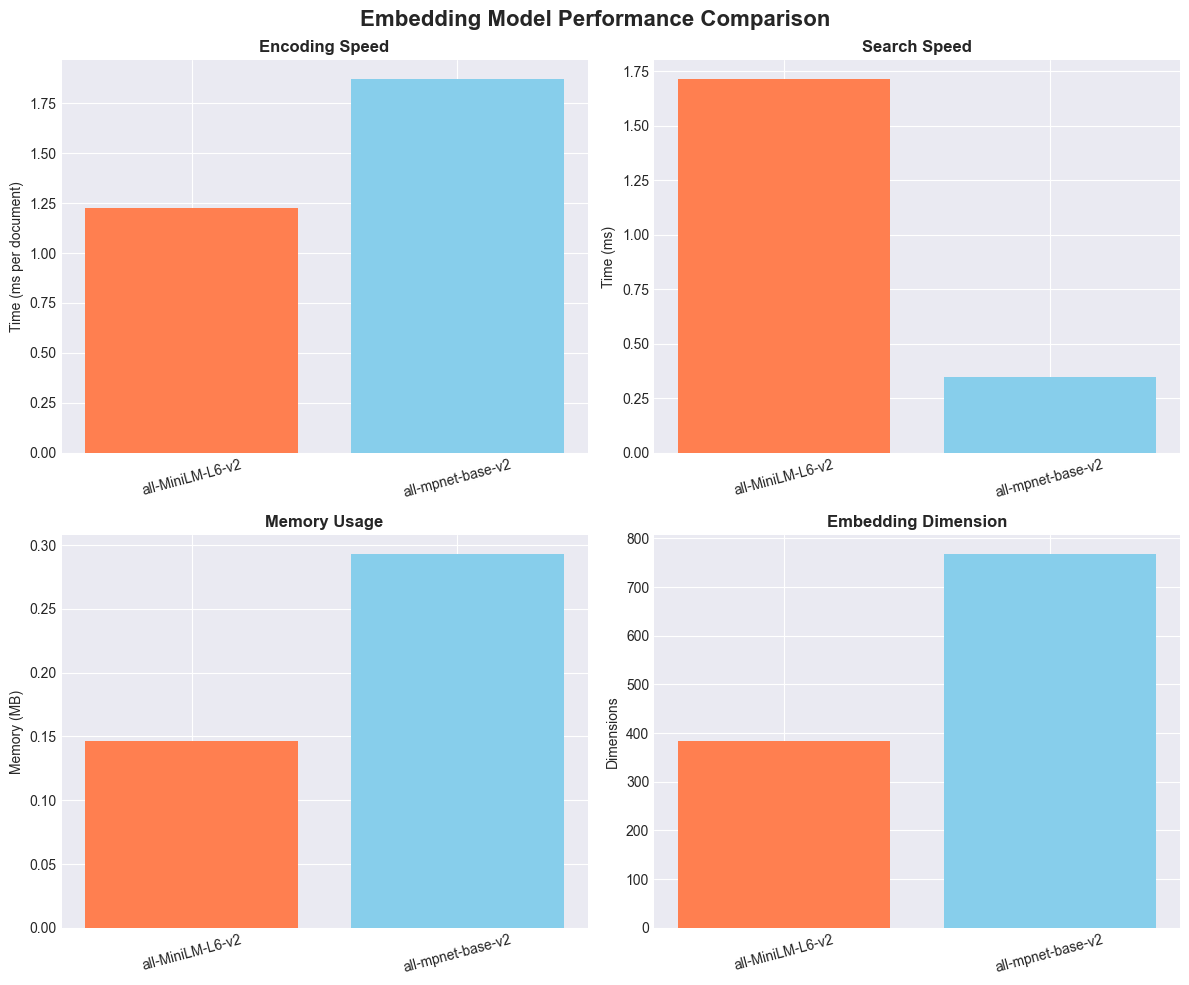

In [29]:
# Visualize performance metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Encoding speed
axes[0, 0].bar(benchmark_df['Model'], benchmark_df['Encoding Time (ms/doc)'], 
               color=['coral', 'skyblue'])
axes[0, 0].set_title('Encoding Speed', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Time (ms per document)')
axes[0, 0].tick_params(axis='x', rotation=15)

# Search speed
axes[0, 1].bar(benchmark_df['Model'], benchmark_df['Search Time (ms)'], 
               color=['coral', 'skyblue'])
axes[0, 1].set_title('Search Speed', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Time (ms)')
axes[0, 1].tick_params(axis='x', rotation=15)

# Memory usage
axes[1, 0].bar(benchmark_df['Model'], benchmark_df['Memory (MB)'], 
               color=['coral', 'skyblue'])
axes[1, 0].set_title('Memory Usage', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Memory (MB)')
axes[1, 0].tick_params(axis='x', rotation=15)

# Dimension comparison
axes[1, 1].bar(benchmark_df['Model'], benchmark_df['Dimension'], 
               color=['coral', 'skyblue'])
axes[1, 1].set_title('Embedding Dimension', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Dimensions')
axes[1, 1].tick_params(axis='x', rotation=15)

plt.suptitle('Embedding Model Performance Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Search Quality Metrics

Let's implement and visualize key search quality metrics:

In [ ]:
# Implement search quality metrics
def calculate_metrics(retrieved, relevant):
    """
    Calculate precision, recall, and F1 score
    """
    retrieved_set = set(retrieved)
    relevant_set = set(relevant)
    
    true_positives = len(retrieved_set & relevant_set)
    
    precision = true_positives / len(retrieved_set) if retrieved_set else 0
    recall = true_positives / len(relevant_set) if relevant_set else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return precision, recall, f1

# Example evaluation
test_cases = [
    {
        'name': 'Perfect Match',
        'retrieved': ['doc1', 'doc2', 'doc3'],
        'relevant': ['doc1', 'doc2', 'doc3']
    },
    {
        'name': 'Partial Match',
        'retrieved': ['doc1', 'doc2', 'doc5'],
        'relevant': ['doc2', 'doc3', 'doc5']
    },
    {
        'name': 'Poor Match',
        'retrieved': ['doc1', 'doc4', 'doc6'],
        'relevant': ['doc2', 'doc3', 'doc5']
    }
]

metrics_results = []
for case in test_cases:
    precision, recall, f1 = calculate_metrics(case['retrieved'], case['relevant'])
    metrics_results.append({
        'Scenario': case['name'],
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

metrics_df = pd.DataFrame(metrics_results)

# Visualize metrics
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(metrics_df))
width = 0.25

bars1 = ax.bar(x - width, metrics_df['Precision'], width, label='Precision', color='lightcoral')
bars2 = ax.bar(x, metrics_df['Recall'], width, label='Recall', color='skyblue')
bars3 = ax.bar(x + width, metrics_df['F1 Score'], width, label='F1 Score', color='lightgreen')

ax.set_xlabel('Scenario', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Search Quality Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_df['Scenario'])
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n📊 Metrics Explanation:")
print("- Precision: What fraction of retrieved results are relevant?")
print("- Recall: What fraction of relevant documents were retrieved?")
print("- F1 Score: Harmonic mean of precision and recall")

<a id='exercises'></a>
## 10. Exercises and Challenges

Now it's your turn! Try these exercises to reinforce your learning:

### Exercise 1: Build Your Own FAQ Search System

Create a semantic search system for your own domain. Start with the template below:

In [ ]:
# Exercise 1: Create your own FAQ system
# TODO: Replace with your own FAQs
your_faqs = [
    # Add at least 10 FAQs from your domain
]

# TODO: Implement semantic search
def create_faq_search_system(faqs):
    """
    Create a semantic search system for FAQs
    
    Returns: (model, embeddings) tuple
    """
    # Your code here
    pass

# TODO: Test with various queries
test_queries = [
    # Add test queries
]

# Your implementation here

### Exercise 2: Optimize Hybrid Search Weights

Find the optimal keyword/semantic weight combination for your dataset:

In [ ]:
# Exercise 2: Optimize hybrid search weights
# TODO: Create a grid search to find optimal weights

weight_combinations = [
    (0.0, 1.0),  # Pure semantic
    (0.2, 0.8),
    (0.4, 0.6),
    (0.5, 0.5),
    (0.6, 0.4),
    (0.8, 0.2),
    (1.0, 0.0),  # Pure keyword
]

# TODO: Evaluate each combination
# Hint: Use precision, recall, or user feedback as metrics

# Your implementation here

### Exercise 3: Build a Mini RAG System

Create a RAG system for a specific domain (e.g., technical documentation, recipes, travel guides):

In [ ]:
# Exercise 3: Build a domain-specific RAG system
# TODO: Choose a domain and create a knowledge base

domain_knowledge = [
    # Add domain-specific documents
]

# TODO: Implement RAG pipeline
class DomainRAG:
    def __init__(self, knowledge_base):
        # Your initialization code
        pass
    
    def answer_question(self, question):
        # Your RAG implementation
        pass

# Your implementation here

## Conclusion

Congratulations! You've completed the interactive tutorial on Semantic Search and Information Retrieval with Transformers. 

### Key Takeaways:

1. **Semantic search** understands meaning, not just keywords
2. **Embeddings** are the foundation of semantic understanding
3. **Hybrid search** combines the best of keyword and semantic approaches
4. **Vector databases** enable scalable similarity search
5. **Multilingual models** work across language barriers
6. **RAG** combines retrieval with generation for better AI responses

### Next Steps:

- Experiment with different embedding models
- Build a production-ready search system
- Explore advanced techniques like cross-encoders and reranking
- Fine-tune models for your specific domain

### Resources:

- [Sentence Transformers Documentation](https://www.sbert.net/)
- [FAISS Documentation](https://github.com/facebookresearch/faiss)
- [Hugging Face Course](https://huggingface.co/course)
- [Rick Hightower's Blog](https://cloudurable.com/blog/)

Happy searching! 🔍🚀